# Problem Statement
A home electronics company, which manufactures state of the art smart televisions, want to develop a cool feature in the smart-TV that can recognise five different gestures. Gestures will be performed by the users. The feature will help users to control the TV without using a remote. The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

# Objective
As a data scientist at the company, we need to build a model that can correctly
predict the 5 gestures.

# Understanding the Dataset
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Few things to note:  

1. all images in a particular video subfolder have the same dimensions
2. different videos may have different dimensions
3. Specifically, videos have two types of dimensions - either 360x360 or 120x160


Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.



In [68]:
project_data_dir = '/datasets/Project_data/'
train_data_dir = '/datasets/Project_data/train/'
val_data_dir = '/datasets/Project_data/val/'
models_dir = '/models/'

# Importing required libraries

In [69]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import random as rn
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, MobileNetV2
from keras.layers import Conv3D, Dense, MaxPooling3D, MaxPooling2D, GRU, Flatten, Dropout, Reshape, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")


In [70]:
# Set seeds for reproducibility
rn.seed(30)
np.random.seed(30)
tf.random.set_seed(30)

In [71]:
train_folder_list = np.random.permutation(open(project_data_dir+'train.csv').readlines())
val_folder_list = np.random.permutation(open(project_data_dir+'val.csv').readlines())

In [72]:
num_train_sequences = len(train_folder_list)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_folder_list)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


# Generator
We are providing a generator function.This type of function is very useful in machine learning for handling large datasets that might not fit into your computer's memory all at once. Instead of loading the entire dataset, a generator loads and processes data in smaller chunks called "batches".



### Utility functions

In [73]:
def crop_image(img):
    width, height = img.size
    min_dim = min(height, width)
    if width == height:
        min_dim = 250
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = (width + min_dim) // 2
    bottom = (height + min_dim) // 2
    cropped_img = img.crop((left, top, right, bottom))
    return cropped_img

In [74]:
def random_image_transformation(img):
    if np.random.randn() > 0:
        img = img.rotate(30)
    if np.random.randn() > 0:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    return img


In [75]:
def generator(source_path, folder_list, img_idx=[], batch_size=64, img_size=(120,120)):
    '''
    source_path image location
    folder_list folders having information about videos
    batch_size number of videos processed at a time
    img_size a tuple having width and height to resige the image
    '''
    print('Source path = ', source_path, '; batch size =', batch_size)
    if len(img_idx) == 0:
        img_idx = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list) #used to shuffle the order of the videos
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_size[0],img_size[1],3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    #image = imread(source_pat+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    filename = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    try:
                        with Image.open(filename) as img:
                            img.load()
                            img = crop_image(img)
                            img = img.resize(img_size, resample = Image.BILINEAR)
                            img = random_image_transformation(img)
                            narray = np.asarray(img)

                            batch_data[folder,idx,:,:,0] = narray[:,:,0]/255
                            batch_data[folder,idx,:,:,1] = narray[:,:,1]/255
                            batch_data[folder,idx,:,:,2] = narray[:,:,2]/255
                    except Exception as e:
                        print(f"Error processing image {filename}: {e}")
                        # Handle the error, e.g., skip the image or fill with a default value
                        batch_data[folder, idx, :, :, :] = 0  # Fill with zeros as a placeholder

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # Handle remaining data points that are left after full batches
        remaining_samples = len(folder_list) % batch_size
        if remaining_samples > 0:
            batch_data = np.zeros((remaining_samples, len(img_idx), img_size[0],img_size[1], 3))
            batch_labels = np.zeros((remaining_samples, 5))
            for folder in range(remaining_samples):
                imgs = os.listdir(source_path + '/' + t[num_batches * batch_size + folder].split(';')[0])
                for idx, item in enumerate(img_idx):
                    filename = source_path + '/' + t[num_batches * batch_size + folder].strip().split(';')[0] + '/' + imgs[item]
                    try:
                        with Image.open(filename) as img:
                            img.load()
                            img = crop_image(img)
                            img = img.resize(img_size, resample = Image.BILINEAR)
                            img = random_image_transformation(img)
                            narray = np.asarray(img)
                            batch_data[folder, idx, :, :, 0] = narray[:, :, 0] / 255
                            batch_data[folder, idx, :, :, 1] = narray[:, :, 1] / 255
                            batch_data[folder, idx, :, :, 2] = narray[:, :, 2] / 255
                    except Exception as e:
                        print(f"Error processing image {filename}: {e}")
                        batch_data[folder, idx, :, :, :] = 0
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


### Validating the Generator

In [76]:
# check complete batch shape
sample_generator = generator(train_data_dir, train_folder_list, batch_size=32)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_data_dir, val_folder_list, batch_size=32)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /datasets/Project_data/train/ ; batch size = 32
(32, 20, 120, 120, 3)
Source path =  /datasets/Project_data/val/ ; batch size = 32
(32, 20, 120, 120, 3)


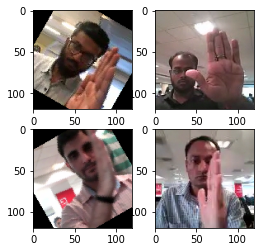

In [77]:
fig, ax = plt.subplots(2,2, figsize=(4,4))
ax[0,0].imshow(sample_batch_data[16,10,:,:,:])
ax[0,1].imshow(sample_batch_data[25,10,:,:,:])

ax[1,0].imshow(sample_val_batch_data[16,10,:,:,:])
ax[1,1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

# Model Creation

### model utilities

In [78]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())

    # fig, ax = plt.subplots(1,2, figsize=(16,8))

    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [79]:
def model_callbacks():
    curr_dt_time = datetime.datetime.now()
    model_name = models_dir + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.makedirs(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]


In [80]:
def train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=64, num_epochs=25):
    """
    Trains a given model.

    Args:
        model: model to train.
        train_ds: The training dataset.
        val_ds: The validation dataset.
        epochs: The number of epochs to train for.

    Returns:
        The training history.
    """

    # defining callbacks
    callbacks_list = model_callbacks()

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps,initial_epoch=0)

    return history


### Experiment 1: Conv3D
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 64
- epochs: 25


In [81]:
train_generator = generator(train_data_dir, train_folder_list)
val_generator = generator(val_data_dir, val_folder_list)

In [82]:
# model = Sequential()
# sample_shape = (20, 120, 120, 3)
# no_classes = 5
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(no_classes, activation='softmax'))

# model.summary()

In [83]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['categorical_accuracy'])

In [84]:
# history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, 200)

Source path =  /datasets/Project_data/train/ ; batch size = 64
Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 4.0207 - categorical_accuracy: 0.2070Source path =  /datasets/Project_data/val/ ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.60333, saving model to /models/model_init_2025-04-0113_23_41.904195/model-00001-4.02068-0.20703-1.60333-0.20312.h5
4/4 [==============================] - 17s 5s/step - loss: 4.0207 - categorical_accuracy: 0.2070 - val_loss: 1.6033 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 1.6057 - categorical_accuracy: 0.1602
Epoch 00002: val_loss improved from 1.60333 to 1.58362, saving model to /models/model_init_2025-04-0113_23_41.904195/model-00002-1.60566-0.16016-1.58362-0.31250.h5
4/4 [==============================] - 16s 5s/step - loss: 1.6057 - categorical_accuracy: 0.1602 - val_loss: 1.5836 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 1.6377 - categorical_accuracy: 0.2140
Epoch 00003: val_loss did not improve from 1.58362
4/4 [==============================] - 14s 4s/step - loss: 1.6377 - categorical_accuracy: 0.2140 - val_loss: 1.6058 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 1.5925 - categorical_accuracy: 0.1953
Epoch 00004: val_loss did not improve from 1.58362
4/4 [==============================] - 16s 5s/step - loss: 1.5925 - categorical_accuracy: 0.1953 - val_loss: 1.6022 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 5/25
4/4 [==============================] - ETA: 0s - loss: 1.6049 - categorical_accuracy: 0.2266
Epoch 00005: val_loss did not improve from 1.58362

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4/4 [==============================] - 16s 5s/step - loss: 1.6049 - categorical_accuracy: 0.2266 - val_loss: 1.6094 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 6/25
4/4 [==============================] - ETA: 0s - loss: 1.6078 - categorical_accuracy: 0.2186
Epoch 00006: val_loss did not improve from 1.58362
4/4 [==============================] - 14s 4s/step - loss: 1.6078 - categorical_accuracy: 0.2186 - val_loss: 1.6100 - val_categorical_accuracy: 0.1719 - lr: 1.0000e-04
Epoch 7/25
4/4 [==============================] - ETA: 0s - loss: 1.6071 - categorical_accuracy: 0.1953
Epoch 00007: val_loss did not improve from 1.58362
4/4 [==============================] - 15s 5s/step - loss: 1.6071 - categorical_accuracy: 0.1953 - val_loss: 1.6086 - val_categorical_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 8/25
4/4 [==============================] - ETA: 0s - loss: 1.6076 - categorical_accuracy: 0.1992
Epoch 00008: val_loss did not improve from 1.58362

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0001.
4/4 [==============================] - 15s 5s/step - loss: 1.6076 - categorical_accuracy: 0.1992 - val_loss: 1.6077 - val_categorical_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 9/25
4/4 [==============================] - ETA: 0s - loss: 1.6058 - categorical_accuracy: 0.2140
Epoch 00009: val_loss did not improve from 1.58362
4/4 [==============================] - 16s 5s/step - loss: 1.6058 - categorical_accuracy: 0.2140 - val_loss: 1.6055 - val_categorical_accuracy: 0.2344 - lr: 1.0000e-04
Epoch 10/25
4/4 [==============================] - ETA: 0s - loss: 1.6039 - categorical_accuracy: 0.2500
Epoch 00010: val_loss did not improve from 1.58362
4/4 [==============================] - 16s 5s/step - loss: 1.6039 - categorical_accuracy: 0.2500 - val_loss: 1.6037 - val_categorical_accuracy: 0.2188 - lr: 1.0000e-04
Epoch 11/25
4/4 [==============================] - ETA: 0s - loss: 1.6034 - categorical_accuracy: 0.2837
Epoch 00011: val_loss did not improve from 1.58362
4/4 [==============================] - 14s 4s/step - loss: 1.6034 - categorical_accuracy: 0.2837 - val_loss: 1.6035 - val_categorical_accuracy: 0.3281 - lr: 1.0000e-04
Epoch 12/25
4/4 [==============================] - ETA: 0s - loss: 1.6024 - categorical_accuracy: 0.2266
Epoch 00012: val_loss did not improve from 1.58362
4/4 [==============================] - 16s 5s/step - loss: 1.6024 - categorical_accuracy: 0.2266 - val_loss: 1.5973 - val_categorical_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 13/25
4/4 [==============================] - ETA: 0s - loss: 1.5987 - categorical_accuracy: 0.3164
Epoch 00013: val_loss did not improve from 1.58362
4/4 [==============================] - 16s 5s/step - loss: 1.5987 - categorical_accuracy: 0.3164 - val_loss: 1.5968 - val_categorical_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 14/25
4/4 [==============================] - ETA: 0s - loss: 1.5955 - categorical_accuracy: 0.2791
Epoch 00014: val_loss did not improve from 1.58362
4/4 [==============================] - 14s 4s/step - loss: 1.5955 - categorical_accuracy: 0.2791 - val_loss: 1.5948 - val_categorical_accuracy: 0.2812 - lr: 1.0000e-04
Epoch 15/25
4/4 [==============================] - ETA: 0s - loss: 1.5959 - categorical_accuracy: 0.2500
Epoch 00015: val_loss did not improve from 1.58362
4/4 [==============================] - 16s 5s/step - loss: 1.5959 - categorical_accuracy: 0.2500 - val_loss: 1.5868 - val_categorical_accuracy: 0.2812 - lr: 1.0000e-04
Epoch 16/25
4/4 [==============================] - ETA: 0s - loss: 1.5860 - categorical_accuracy: 0.3008
Epoch 00016: val_loss improved from 1.58362 to 1.57558, saving model to /models/model_init_2025-04-0113_23_41.904195/model-00016-1.58600-0.30078-1.57558-0.34375.h5
4/4 [==============================] - 16s 5s/step - loss: 1.5860 - categorical_accuracy: 0.3008 - val_loss: 1.5756 - val_categorical_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 17/25
4/4 [==============================] - ETA: 0s - loss: 1.5902 - categorical_accuracy: 0.2140
Epoch 00017: val_loss did not improve from 1.57558
4/4 [==============================] - 14s 5s/step - loss: 1.5902 - categorical_accuracy: 0.2140 - val_loss: 1.5766 - val_categorical_accuracy: 0.2656 - lr: 1.0000e-04
Epoch 18/25
4/4 [==============================] - ETA: 0s - loss: 1.5910 - categorical_accuracy: 0.2383
Epoch 00018: val_loss did not improve from 1.57558
4/4 [==============================] - 16s 5s/step - loss: 1.5910 - categorical_accuracy: 0.2383 - val_loss: 1.5920 - val_categorical_accuracy: 0.2344 - lr: 1.0000e-04
Epoch 19/25
4/4 [==============================] - ETA: 0s - loss: 1.5838 - categorical_accuracy: 0.2422
Epoch 00019: val_loss did not improve from 1.57558
4/4 [==============================] - 16s 5s/step - loss: 1.5838 - categorical_accuracy: 0.2422 - val_loss: 1.5811 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 20/25
4/4 [==============================] - ETA: 0s - loss: 1.5864 - categorical_accuracy: 0.2000
Epoch 00020: val_loss improved from 1.57558 to 1.57163, saving model to /models/model_init_2025-04-0113_23_41.904195/model-00020-1.58640-0.20000-1.57163-0.25000.h5
4/4 [==============================] - 16s 5s/step - loss: 1.5864 - categorical_accuracy: 0.2000 - val_loss: 1.5716 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 21/25
4/4 [==============================] - ETA: 0s - loss: 1.5808 - categorical_accuracy: 0.2227
Epoch 00021: val_loss did not improve from 1.57163
4/4 [==============================] - 16s 5s/step - loss: 1.5808 - categorical_accuracy: 0.2227 - val_loss: 1.5784 - val_categorical_accuracy: 0.2344 - lr: 1.0000e-04
Epoch 22/25
4/4 [==============================] - ETA: 0s - loss: 1.5580 - categorical_accuracy: 0.2837
Epoch 00022: val_loss improved from 1.57163 to 1.57053, saving model to /models/model_init_2025-04-0113_23_41.904195/model-00022-1.55801-0.28372-1.57053-0.25000.h5
4/4 [==============================] - 14s 5s/step - loss: 1.5580 - categorical_accuracy: 0.2837 - val_loss: 1.5705 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 23/25
4/4 [==============================] - ETA: 0s - loss: 1.5651 - categorical_accuracy: 0.2305
Epoch 00023: val_loss improved from 1.57053 to 1.55037, saving model to /models/model_init_2025-04-0113_23_41.904195/model-00023-1.56509-0.23047-1.55037-0.26562.h5
4/4 [==============================] - 16s 5s/step - loss: 1.5651 - categorical_accuracy: 0.2305 - val_loss: 1.5504 - val_categorical_accuracy: 0.2656 - lr: 1.0000e-04
Epoch 24/25
4/4 [==============================] - ETA: 0s - loss: 1.5830 - categorical_accuracy: 0.2109
Epoch 00024: val_loss did not improve from 1.55037
4/4 [==============================] - 16s 5s/step - loss: 1.5830 - categorical_accuracy: 0.2109 - val_loss: 1.5587 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 25/25
4/4 [==============================] - ETA: 0s - loss: 1.5485 - categorical_accuracy: 0.2698
Epoch 00025: val_loss did not improve from 1.55037
4/4 [==============================] - 14s 4s/step - loss: 1.5485 - categorical_accuracy: 0.2698 - val_loss: 1.5776 - val_categorical_accuracy: 0.2344 - lr: 1.0000e-04

In [85]:
#plot_loss_accuracy(history)

### Experiment 1 Observations:
- Both, val and train accuracy are very less

### Experiment 1 Conclusion
Clearly, model created in experiment 1 is performing poor. 

### Experiment 2: Conv3D with more layers
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 64
- epochs: 30

In [86]:
# model = Sequential()
# sample_shape = (20, 120, 120, 3)
# no_classes = 5
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(no_classes, activation='softmax'))

# model.summary()


In [87]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['categorical_accuracy'])

In [88]:
# history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, num_epochs=30)

Source path =  /datasets/Project_data/train/ ; batch size = 64
Epoch 1/30
2025-04-01 13:56:10.565564: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-04-01 13:56:13.394037: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
11/11 [==============================] - ETA: 0s - loss: 2.1230 - categorical_accuracy: 0.2036Source path =  /datasets/Project_data/val/ ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.60707, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00001-2.12298-0.20362-1.60707-0.18000.h5
11/11 [==============================] - 46s 4s/step - loss: 2.1230 - categorical_accuracy: 0.2036 - val_loss: 1.6071 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.6063 - categorical_accuracy: 0.2112
Epoch 00002: val_loss improved from 1.60707 to 1.57970, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00002-1.60629-0.21116-1.57970-0.20000.h5
11/11 [==============================] - 40s 4s/step - loss: 1.6063 - categorical_accuracy: 0.2112 - val_loss: 1.5797 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.5816 - categorical_accuracy: 0.2383
Epoch 00003: val_loss improved from 1.57970 to 1.53929, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00003-1.58160-0.23831-1.53929-0.32000.h5
11/11 [==============================] - 40s 4s/step - loss: 1.5816 - categorical_accuracy: 0.2383 - val_loss: 1.5393 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 1.5414 - categorical_accuracy: 0.3258
Epoch 00004: val_loss improved from 1.53929 to 1.43516, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00004-1.54135-0.32579-1.43516-0.34000.h5
11/11 [==============================] - 39s 4s/step - loss: 1.5414 - categorical_accuracy: 0.3258 - val_loss: 1.4352 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 5/30
11/11 [==============================] - ETA: 0s - loss: 1.4111 - categorical_accuracy: 0.3771
Epoch 00005: val_loss improved from 1.43516 to 1.33534, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00005-1.41113-0.37707-1.33534-0.46000.h5
11/11 [==============================] - 42s 4s/step - loss: 1.4111 - categorical_accuracy: 0.3771 - val_loss: 1.3353 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 6/30
11/11 [==============================] - ETA: 0s - loss: 1.3415 - categorical_accuracy: 0.3937
Epoch 00006: val_loss improved from 1.33534 to 1.27147, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00006-1.34149-0.39367-1.27147-0.47000.h5
11/11 [==============================] - 39s 4s/step - loss: 1.3415 - categorical_accuracy: 0.3937 - val_loss: 1.2715 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 7/30
11/11 [==============================] - ETA: 0s - loss: 1.4081 - categorical_accuracy: 0.3756
Epoch 00007: val_loss did not improve from 1.27147
11/11 [==============================] - 39s 4s/step - loss: 1.4081 - categorical_accuracy: 0.3756 - val_loss: 1.4761 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 8/30
11/11 [==============================] - ETA: 0s - loss: 1.3614 - categorical_accuracy: 0.4133
Epoch 00008: val_loss did not improve from 1.27147
11/11 [==============================] - 38s 4s/step - loss: 1.3614 - categorical_accuracy: 0.4133 - val_loss: 1.2914 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 9/30
11/11 [==============================] - ETA: 0s - loss: 1.2820 - categorical_accuracy: 0.4359
Epoch 00009: val_loss did not improve from 1.27147

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
11/11 [==============================] - 40s 4s/step - loss: 1.2820 - categorical_accuracy: 0.4359 - val_loss: 1.2722 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 10/30
11/11 [==============================] - ETA: 0s - loss: 1.2577 - categorical_accuracy: 0.4570
Epoch 00010: val_loss improved from 1.27147 to 1.26690, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00010-1.25774-0.45701-1.26690-0.38000.h5
11/11 [==============================] - 38s 4s/step - loss: 1.2577 - categorical_accuracy: 0.4570 - val_loss: 1.2669 - val_categorical_accuracy: 0.3800 - lr: 1.0000e-04
Epoch 11/30
11/11 [==============================] - ETA: 0s - loss: 1.2184 - categorical_accuracy: 0.4661
Epoch 00011: val_loss improved from 1.26690 to 1.19050, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00011-1.21839-0.46606-1.19050-0.52000.h5
11/11 [==============================] - 40s 4s/step - loss: 1.2184 - categorical_accuracy: 0.4661 - val_loss: 1.1905 - val_categorical_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 12/30
11/11 [==============================] - ETA: 0s - loss: 1.2021 - categorical_accuracy: 0.4751
Epoch 00012: val_loss improved from 1.19050 to 1.18416, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00012-1.20206-0.47511-1.18416-0.41000.h5
11/11 [==============================] - 39s 4s/step - loss: 1.2021 - categorical_accuracy: 0.4751 - val_loss: 1.1842 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04
Epoch 13/30
11/11 [==============================] - ETA: 0s - loss: 1.1882 - categorical_accuracy: 0.4947
Epoch 00013: val_loss improved from 1.18416 to 1.15148, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00013-1.18816-0.49472-1.15148-0.45000.h5
11/11 [==============================] - 40s 4s/step - loss: 1.1882 - categorical_accuracy: 0.4947 - val_loss: 1.1515 - val_categorical_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 14/30
11/11 [==============================] - ETA: 0s - loss: 1.1816 - categorical_accuracy: 0.4736
Epoch 00014: val_loss improved from 1.15148 to 1.09494, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00014-1.18163-0.47360-1.09494-0.53000.h5
11/11 [==============================] - 38s 4s/step - loss: 1.1816 - categorical_accuracy: 0.4736 - val_loss: 1.0949 - val_categorical_accuracy: 0.5300 - lr: 1.0000e-04
Epoch 15/30
11/11 [==============================] - ETA: 0s - loss: 1.1778 - categorical_accuracy: 0.4872
Epoch 00015: val_loss did not improve from 1.09494
11/11 [==============================] - 39s 4s/step - loss: 1.1778 - categorical_accuracy: 0.4872 - val_loss: 1.1394 - val_categorical_accuracy: 0.4900 - lr: 1.0000e-04
Epoch 16/30
11/11 [==============================] - ETA: 0s - loss: 1.1567 - categorical_accuracy: 0.5008
Epoch 00016: val_loss did not improve from 1.09494
11/11 [==============================] - 38s 4s/step - loss: 1.1567 - categorical_accuracy: 0.5008 - val_loss: 1.1244 - val_categorical_accuracy: 0.5700 - lr: 1.0000e-04
Epoch 17/30
11/11 [==============================] - ETA: 0s - loss: 1.1519 - categorical_accuracy: 0.4977
Epoch 00017: val_loss did not improve from 1.09494

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0001.
11/11 [==============================] - 40s 4s/step - loss: 1.1519 - categorical_accuracy: 0.4977 - val_loss: 1.1223 - val_categorical_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 18/30
11/11 [==============================] - ETA: 0s - loss: 1.1455 - categorical_accuracy: 0.5083
Epoch 00018: val_loss did not improve from 1.09494
11/11 [==============================] - 38s 4s/step - loss: 1.1455 - categorical_accuracy: 0.5083 - val_loss: 1.1633 - val_categorical_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 19/30
11/11 [==============================] - ETA: 0s - loss: 1.1368 - categorical_accuracy: 0.4902
Epoch 00019: val_loss did not improve from 1.09494
11/11 [==============================] - 39s 4s/step - loss: 1.1368 - categorical_accuracy: 0.4902 - val_loss: 1.1544 - val_categorical_accuracy: 0.5300 - lr: 1.0000e-04
Epoch 20/30
11/11 [==============================] - ETA: 0s - loss: 1.1296 - categorical_accuracy: 0.5068
Epoch 00020: val_loss did not improve from 1.09494
11/11 [==============================] - 38s 4s/step - loss: 1.1296 - categorical_accuracy: 0.5068 - val_loss: 1.1634 - val_categorical_accuracy: 0.5300 - lr: 1.0000e-04
Epoch 21/30
11/11 [==============================] - ETA: 0s - loss: 1.1281 - categorical_accuracy: 0.5204
Epoch 00021: val_loss did not improve from 1.09494
11/11 [==============================] - 39s 4s/step - loss: 1.1281 - categorical_accuracy: 0.5204 - val_loss: 1.0951 - val_categorical_accuracy: 0.5300 - lr: 1.0000e-04
Epoch 22/30
11/11 [==============================] - ETA: 0s - loss: 1.1077 - categorical_accuracy: 0.5324
Epoch 00022: val_loss did not improve from 1.09494
11/11 [==============================] - 38s 4s/step - loss: 1.1077 - categorical_accuracy: 0.5324 - val_loss: 1.1516 - val_categorical_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 23/30
11/11 [==============================] - ETA: 0s - loss: 1.1065 - categorical_accuracy: 0.5400
Epoch 00023: val_loss improved from 1.09494 to 1.03306, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00023-1.10653-0.53997-1.03306-0.54000.h5
11/11 [==============================] - 40s 4s/step - loss: 1.1065 - categorical_accuracy: 0.5400 - val_loss: 1.0331 - val_categorical_accuracy: 0.5400 - lr: 1.0000e-04
Epoch 24/30
11/11 [==============================] - ETA: 0s - loss: 1.0866 - categorical_accuracy: 0.5264
Epoch 00024: val_loss did not improve from 1.03306
11/11 [==============================] - 38s 4s/step - loss: 1.0866 - categorical_accuracy: 0.5264 - val_loss: 1.1299 - val_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 25/30
11/11 [==============================] - ETA: 0s - loss: 1.0826 - categorical_accuracy: 0.5460
Epoch 00025: val_loss did not improve from 1.03306
11/11 [==============================] - 39s 4s/step - loss: 1.0826 - categorical_accuracy: 0.5460 - val_loss: 1.0464 - val_categorical_accuracy: 0.5400 - lr: 1.0000e-04
Epoch 26/30
11/11 [==============================] - ETA: 0s - loss: 1.0640 - categorical_accuracy: 0.5475
Epoch 00026: val_loss improved from 1.03306 to 0.97513, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00026-1.06397-0.54751-0.97513-0.62000.h5
11/11 [==============================] - 38s 4s/step - loss: 1.0640 - categorical_accuracy: 0.5475 - val_loss: 0.9751 - val_categorical_accuracy: 0.6200 - lr: 1.0000e-04
Epoch 27/30
11/11 [==============================] - ETA: 0s - loss: 1.0612 - categorical_accuracy: 0.5400
Epoch 00027: val_loss did not improve from 0.97513
11/11 [==============================] - 40s 4s/step - loss: 1.0612 - categorical_accuracy: 0.5400 - val_loss: 1.0323 - val_categorical_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 28/30
11/11 [==============================] - ETA: 0s - loss: 1.0580 - categorical_accuracy: 0.5324
Epoch 00028: val_loss improved from 0.97513 to 0.97324, saving model to /models/model_init_2025-04-0113_56_04.464416/model-00028-1.05798-0.53243-0.97324-0.56000.h5
11/11 [==============================] - 38s 4s/step - loss: 1.0580 - categorical_accuracy: 0.5324 - val_loss: 0.9732 - val_categorical_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 29/30
11/11 [==============================] - ETA: 0s - loss: 1.0433 - categorical_accuracy: 0.5671
Epoch 00029: val_loss did not improve from 0.97324
11/11 [==============================] - 39s 4s/step - loss: 1.0433 - categorical_accuracy: 0.5671 - val_loss: 1.0668 - val_categorical_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 30/30
11/11 [==============================] - ETA: 0s - loss: 1.0073 - categorical_accuracy: 0.5913
Epoch 00030: val_loss did not improve from 0.97324
11/11 [==============================] - 38s 4s/step - loss: 1.0073 - categorical_accuracy: 0.5913 - val_loss: 0.9767 - val_categorical_accuracy: 0.6400 - lr: 1.0000e-04

In [89]:
#plot_loss_accuracy(history)

### Experiment 2 Observations
Difference between train and val accuracy has been reduced.

### Experiment 2 Conclusion
Accuracy is still low; let's pass all the images to the model

### Experiment 3 :
- frames per video: 30
- frame (image) size: 120 * 120
- batch size: 32 (initially tried with 100; OOM was thrown)
- epochs: 40


In [90]:
# img_idx_list = [i for i in range(30)]
# train_generator = generator(train_data_dir, train_folder_list, img_idx_list, batch_size=32)
# val_generator = generator(val_data_dir, val_folder_list, img_idx_list, batch_size=32)

In [91]:
# model = Sequential()
# sample_shape = (30, 120, 120, 3)
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(no_classes, activation='softmax'))

# model.summary()


In [92]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['categorical_accuracy'])

In [93]:
#history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences,32,40)

Source path =  /datasets/Project_data/train/ ; batch size = 32
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 1.8117 - categorical_accuracy: 0.1961Source path =  /datasets/Project_data/val/ ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.60447, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00001-1.81173-0.19608-1.60447-0.18000.h5
21/21 [==============================] - 62s 3s/step - loss: 1.8117 - categorical_accuracy: 0.1961 - val_loss: 1.6045 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 1.6067 - categorical_accuracy: 0.2172
Epoch 00002: val_loss did not improve from 1.60447
21/21 [==============================] - 61s 3s/step - loss: 1.6067 - categorical_accuracy: 0.2172 - val_loss: 1.6091 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 1.5947 - categorical_accuracy: 0.2443
Epoch 00003: val_loss did not improve from 1.60447
21/21 [==============================] - 59s 3s/step - loss: 1.5947 - categorical_accuracy: 0.2443 - val_loss: 1.6597 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/40
21/21 [==============================] - ETA: 0s - loss: 1.5720 - categorical_accuracy: 0.2670
Epoch 00004: val_loss improved from 1.60447 to 1.49836, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00004-1.57198-0.26697-1.49836-0.36000.h5
21/21 [==============================] - 57s 3s/step - loss: 1.5720 - categorical_accuracy: 0.2670 - val_loss: 1.4984 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 5/40
21/21 [==============================] - ETA: 0s - loss: 1.5244 - categorical_accuracy: 0.2926
Epoch 00005: val_loss did not improve from 1.49836
21/21 [==============================] - 59s 3s/step - loss: 1.5244 - categorical_accuracy: 0.2926 - val_loss: 1.5533 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 6/40
21/21 [==============================] - ETA: 0s - loss: 1.4447 - categorical_accuracy: 0.3348
Epoch 00006: val_loss improved from 1.49836 to 1.38713, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00006-1.44467-0.33484-1.38713-0.33000.h5
21/21 [==============================] - 59s 3s/step - loss: 1.4447 - categorical_accuracy: 0.3348 - val_loss: 1.3871 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 7/40
21/21 [==============================] - ETA: 0s - loss: 1.3888 - categorical_accuracy: 0.3529
Epoch 00007: val_loss improved from 1.38713 to 1.36220, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00007-1.38882-0.35294-1.36220-0.39000.h5
21/21 [==============================] - 59s 3s/step - loss: 1.3888 - categorical_accuracy: 0.3529 - val_loss: 1.3622 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 8/40
21/21 [==============================] - ETA: 0s - loss: 1.3911 - categorical_accuracy: 0.3695
Epoch 00008: val_loss improved from 1.36220 to 1.29092, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00008-1.39107-0.36953-1.29092-0.46000.h5
21/21 [==============================] - 56s 3s/step - loss: 1.3911 - categorical_accuracy: 0.3695 - val_loss: 1.2909 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 9/40
21/21 [==============================] - ETA: 0s - loss: 1.2739 - categorical_accuracy: 0.4118
Epoch 00009: val_loss improved from 1.29092 to 1.20215, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00009-1.27386-0.41176-1.20215-0.43000.h5
21/21 [==============================] - 58s 3s/step - loss: 1.2739 - categorical_accuracy: 0.4118 - val_loss: 1.2021 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 10/40
21/21 [==============================] - ETA: 0s - loss: 1.2407 - categorical_accuracy: 0.4148
Epoch 00010: val_loss did not improve from 1.20215
21/21 [==============================] - 58s 3s/step - loss: 1.2407 - categorical_accuracy: 0.4148 - val_loss: 1.4665 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 11/40
21/21 [==============================] - ETA: 0s - loss: 1.2166 - categorical_accuracy: 0.4314
Epoch 00011: val_loss improved from 1.20215 to 1.12595, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00011-1.21661-0.43137-1.12595-0.53000.h5
21/21 [==============================] - 59s 3s/step - loss: 1.2166 - categorical_accuracy: 0.4314 - val_loss: 1.1260 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 12/40
21/21 [==============================] - ETA: 0s - loss: 1.1767 - categorical_accuracy: 0.4691
Epoch 00012: val_loss did not improve from 1.12595
21/21 [==============================] - 56s 3s/step - loss: 1.1767 - categorical_accuracy: 0.4691 - val_loss: 1.1789 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 13/40
21/21 [==============================] - ETA: 0s - loss: 1.1939 - categorical_accuracy: 0.4268
Epoch 00013: val_loss did not improve from 1.12595
21/21 [==============================] - 58s 3s/step - loss: 1.1939 - categorical_accuracy: 0.4268 - val_loss: 1.1638 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 14/40
21/21 [==============================] - ETA: 0s - loss: 1.1730 - categorical_accuracy: 0.5023
Epoch 00014: val_loss improved from 1.12595 to 1.12261, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00014-1.17304-0.50226-1.12261-0.46000.h5
21/21 [==============================] - 59s 3s/step - loss: 1.1730 - categorical_accuracy: 0.5023 - val_loss: 1.1226 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 15/40
21/21 [==============================] - ETA: 0s - loss: 1.1315 - categorical_accuracy: 0.5083
Epoch 00015: val_loss did not improve from 1.12261
21/21 [==============================] - 59s 3s/step - loss: 1.1315 - categorical_accuracy: 0.5083 - val_loss: 1.1424 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 16/40
21/21 [==============================] - ETA: 0s - loss: 1.0856 - categorical_accuracy: 0.5249
Epoch 00016: val_loss improved from 1.12261 to 1.05000, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00016-1.08561-0.52489-1.05000-0.56000.h5
21/21 [==============================] - 57s 3s/step - loss: 1.0856 - categorical_accuracy: 0.5249 - val_loss: 1.0500 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 17/40
21/21 [==============================] - ETA: 0s - loss: 1.0228 - categorical_accuracy: 0.5807
Epoch 00017: val_loss did not improve from 1.05000
21/21 [==============================] - 58s 3s/step - loss: 1.0228 - categorical_accuracy: 0.5807 - val_loss: 1.0910 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 18/40
21/21 [==============================] - ETA: 0s - loss: 1.0959 - categorical_accuracy: 0.5294
Epoch 00018: val_loss did not improve from 1.05000
21/21 [==============================] - 59s 3s/step - loss: 1.0959 - categorical_accuracy: 0.5294 - val_loss: 1.0643 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 19/40
21/21 [==============================] - ETA: 0s - loss: 0.9370 - categorical_accuracy: 0.5913
Epoch 00019: val_loss did not improve from 1.05000

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21/21 [==============================] - 59s 3s/step - loss: 0.9370 - categorical_accuracy: 0.5913 - val_loss: 1.1944 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 20/40
21/21 [==============================] - ETA: 0s - loss: 0.8594 - categorical_accuracy: 0.6546
Epoch 00020: val_loss improved from 1.05000 to 0.98740, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00020-0.85940-0.65460-0.98740-0.65000.h5
21/21 [==============================] - 57s 3s/step - loss: 0.8594 - categorical_accuracy: 0.6546 - val_loss: 0.9874 - val_categorical_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 21/40
21/21 [==============================] - ETA: 0s - loss: 0.8279 - categorical_accuracy: 0.6606
Epoch 00021: val_loss did not improve from 0.98740
21/21 [==============================] - 58s 3s/step - loss: 0.8279 - categorical_accuracy: 0.6606 - val_loss: 1.0327 - val_categorical_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 22/40
21/21 [==============================] - ETA: 0s - loss: 0.8104 - categorical_accuracy: 0.6682
Epoch 00022: val_loss did not improve from 0.98740
21/21 [==============================] - 58s 3s/step - loss: 0.8104 - categorical_accuracy: 0.6682 - val_loss: 1.1006 - val_categorical_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 23/40
21/21 [==============================] - ETA: 0s - loss: 0.8055 - categorical_accuracy: 0.6712
Epoch 00023: val_loss improved from 0.98740 to 0.87473, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00023-0.80550-0.67119-0.87473-0.67000.h5
21/21 [==============================] - 60s 3s/step - loss: 0.8055 - categorical_accuracy: 0.6712 - val_loss: 0.8747 - val_categorical_accuracy: 0.6700 - lr: 1.0000e-04
Epoch 24/40
21/21 [==============================] - ETA: 0s - loss: 0.7638 - categorical_accuracy: 0.6908
Epoch 00024: val_loss did not improve from 0.87473
21/21 [==============================] - 58s 3s/step - loss: 0.7638 - categorical_accuracy: 0.6908 - val_loss: 0.9609 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 25/40
21/21 [==============================] - ETA: 0s - loss: 0.7416 - categorical_accuracy: 0.7014
Epoch 00025: val_loss did not improve from 0.87473
21/21 [==============================] - 59s 3s/step - loss: 0.7416 - categorical_accuracy: 0.7014 - val_loss: 0.9977 - val_categorical_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 26/40
21/21 [==============================] - ETA: 0s - loss: 0.7512 - categorical_accuracy: 0.6817
Epoch 00026: val_loss did not improve from 0.87473

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0001.
21/21 [==============================] - 59s 3s/step - loss: 0.7512 - categorical_accuracy: 0.6817 - val_loss: 0.9696 - val_categorical_accuracy: 0.6900 - lr: 1.0000e-04
Epoch 27/40
21/21 [==============================] - ETA: 0s - loss: 0.7265 - categorical_accuracy: 0.7119
Epoch 00027: val_loss did not improve from 0.87473
21/21 [==============================] - 59s 3s/step - loss: 0.7265 - categorical_accuracy: 0.7119 - val_loss: 0.9869 - val_categorical_accuracy: 0.6700 - lr: 1.0000e-04
Epoch 28/40
21/21 [==============================] - ETA: 0s - loss: 0.7272 - categorical_accuracy: 0.7089
Epoch 00028: val_loss did not improve from 0.87473
21/21 [==============================] - 56s 3s/step - loss: 0.7272 - categorical_accuracy: 0.7089 - val_loss: 0.9710 - val_categorical_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 29/40
21/21 [==============================] - ETA: 0s - loss: 0.7154 - categorical_accuracy: 0.7119
Epoch 00029: val_loss did not improve from 0.87473
21/21 [==============================] - 58s 3s/step - loss: 0.7154 - categorical_accuracy: 0.7119 - val_loss: 1.0278 - val_categorical_accuracy: 0.6700 - lr: 1.0000e-04
Epoch 30/40
21/21 [==============================] - ETA: 0s - loss: 0.7050 - categorical_accuracy: 0.7240
Epoch 00030: val_loss did not improve from 0.87473
21/21 [==============================] - 58s 3s/step - loss: 0.7050 - categorical_accuracy: 0.7240 - val_loss: 0.9856 - val_categorical_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 31/40
21/21 [==============================] - ETA: 0s - loss: 0.6951 - categorical_accuracy: 0.7179
Epoch 00031: val_loss did not improve from 0.87473
21/21 [==============================] - 59s 3s/step - loss: 0.6951 - categorical_accuracy: 0.7179 - val_loss: 0.9897 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 32/40
21/21 [==============================] - ETA: 0s - loss: 0.7055 - categorical_accuracy: 0.7104
Epoch 00032: val_loss did not improve from 0.87473
21/21 [==============================] - 57s 3s/step - loss: 0.7055 - categorical_accuracy: 0.7104 - val_loss: 0.8909 - val_categorical_accuracy: 0.6900 - lr: 1.0000e-04
Epoch 33/40
21/21 [==============================] - ETA: 0s - loss: 0.6965 - categorical_accuracy: 0.7285
Epoch 00033: val_loss did not improve from 0.87473
21/21 [==============================] - 58s 3s/step - loss: 0.6965 - categorical_accuracy: 0.7285 - val_loss: 0.9758 - val_categorical_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 34/40
21/21 [==============================] - ETA: 0s - loss: 0.6686 - categorical_accuracy: 0.7285
Epoch 00034: val_loss did not improve from 0.87473
21/21 [==============================] - 59s 3s/step - loss: 0.6686 - categorical_accuracy: 0.7285 - val_loss: 0.8818 - val_categorical_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 35/40
21/21 [==============================] - ETA: 0s - loss: 0.6676 - categorical_accuracy: 0.7179
Epoch 00035: val_loss did not improve from 0.87473
21/21 [==============================] - 58s 3s/step - loss: 0.6676 - categorical_accuracy: 0.7179 - val_loss: 1.0930 - val_categorical_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 36/40
21/21 [==============================] - ETA: 0s - loss: 0.6569 - categorical_accuracy: 0.7526
Epoch 00036: val_loss improved from 0.87473 to 0.85698, saving model to /models/model_init_2025-04-0114_23_50.572126/model-00036-0.65691-0.75264-0.85698-0.69000.h5
21/21 [==============================] - 56s 3s/step - loss: 0.6569 - categorical_accuracy: 0.7526 - val_loss: 0.8570 - val_categorical_accuracy: 0.6900 - lr: 1.0000e-04
Epoch 37/40
21/21 [==============================] - ETA: 0s - loss: 0.6582 - categorical_accuracy: 0.7119
Epoch 00037: val_loss did not improve from 0.85698
21/21 [==============================] - 59s 3s/step - loss: 0.6582 - categorical_accuracy: 0.7119 - val_loss: 0.9600 - val_categorical_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 38/40
21/21 [==============================] - ETA: 0s - loss: 0.6467 - categorical_accuracy: 0.7345
Epoch 00038: val_loss did not improve from 0.85698
21/21 [==============================] - 59s 3s/step - loss: 0.6467 - categorical_accuracy: 0.7345 - val_loss: 0.9152 - val_categorical_accuracy: 0.7100 - lr: 1.0000e-04
Epoch 39/40
21/21 [==============================] - ETA: 0s - loss: 0.6188 - categorical_accuracy: 0.7481
Epoch 00039: val_loss did not improve from 0.85698
21/21 [==============================] - 59s 3s/step - loss: 0.6188 - categorical_accuracy: 0.7481 - val_loss: 0.8993 - val_categorical_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 40/40
21/21 [==============================] - ETA: 0s - loss: 0.6323 - categorical_accuracy: 0.7360
Epoch 00040: val_loss did not improve from 0.85698
21/21 [==============================] - 59s 3s/step - loss: 0.6323 - categorical_accuracy: 0.7360 - val_loss: 1.0859 - val_categorical_accuracy: 0.6000 - lr: 1.0000e-04

In [94]:
#plot_loss_accuracy(history)

### Experiment 3 Observations
val and train accuracy are same as previous experiment.

### Experiment 3 Conclusion
We need to improve the accuracy; passing more images did not help

### Experiment 4 Adding more layers to the model
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 64
- epochs: 30

In [61]:
train_generator = generator(train_data_dir, train_folder_list)
val_generator = generator(val_data_dir, val_folder_list)

In [96]:
model = Sequential()
sample_shape = (20, 120, 120, 3)
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_38 (Conv3D)          (None, 5, 30, 30, 128)    221312    
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 3, 15, 15, 128) 

In [97]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [98]:
history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, num_epochs=50)

Source path =  /datasets/Project_data/train/ ; batch size = 64
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.6686 - categorical_accuracy: 0.2006Source path =  /datasets/Project_data/val/ ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.59680, saving model to /models/model_init_2025-04-0115_08_22.402613/model-00001-1.66862-0.20060-1.59680-0.23000.h5
11/11 [==============================] - 40s 4s/step - loss: 1.6686 - categorical_accuracy: 0.2006 - val_loss: 1.5968 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.5997 - categorical_accuracy: 0.1976
Epoch 00002: val_loss improved from 1.59680 to 1.55567, saving model to /models/model_init_2025-04-0115_08_22.402613/model-00002-1.59970-0.19759-1.55567-0.24000.h5
11/11 [==============================] - 37s 4s/step - loss: 1.5997 - categorical_accuracy: 0.1976 - val_loss: 1.5557 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


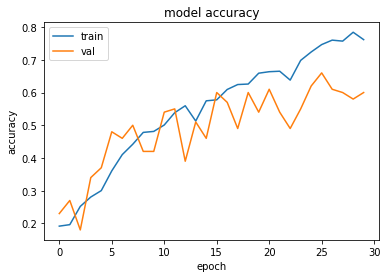

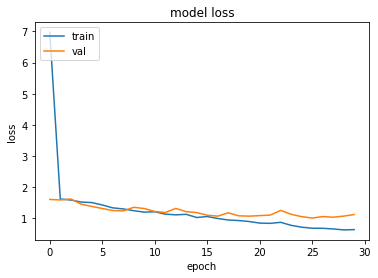

In [73]:
plot_loss_accuracy(history)

### Experiment 4 Observations
val and train accuracy has improved
val loss is still high

### Experiment 4 Conclusion
We need to improve the accuracy; passing more images did not help

### Experiment 5 Conv3D with Average Pooling Layer and dropout

In [75]:
from keras.layers import AveragePooling3D 
model = Sequential()
sample_shape = (20, 120, 120, 3)
no_classes = 5
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(AveragePooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(AveragePooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(AveragePooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(AveragePooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_63 (Conv3D)          (None, 18, 118, 118, 32)  2624      
                                                                 
 average_pooling3d (AverageP  (None, 9, 59, 59, 32)    0         
 ooling3D)                                                       
                                                                 
 conv3d_64 (Conv3D)          (None, 7, 57, 57, 64)     55360     
                                                                 
 average_pooling3d_1 (Averag  (None, 7, 29, 29, 64)    0         
 ePooling3D)                                                     
                                                                 
 conv3d_65 (Conv3D)          (None, 5, 27, 27, 128)    221312    
                                                                 
 average_pooling3d_2 (Averag  (None, 5, 14, 14, 128) 

In [76]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [77]:
history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, num_epochs=30)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 2.2552 - categorical_accuracy: 0.2398
Epoch 00001: val_loss improved from inf to 1.60865, saving model to /models/model_init_2025-03-3117_20_52.510737/model-00001-2.25523-0.23982-1.60865-0.18000.h5
7/7 [==============================] - 29s 5s/step - loss: 2.2552 - categorical_accuracy: 0.2398 - val_loss: 1.6086 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 1.6056 - categorical_accuracy: 0.2021
Epoch 00002: val_loss improved from 1.60865 to 1.57590, saving model to /models/model_init_2025-03-3117_20_52.510737/model-00002-1.60555-0.20211-1.57590-0.24000.h5
7/7 [==============================] - 29s 5s/step - loss: 1.6056 - categorical_accuracy: 0.2021 - val_loss: 1.5759 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 1.5498 - categorical_accuracy: 0.2715
Epoch 00003: val_loss improved from 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


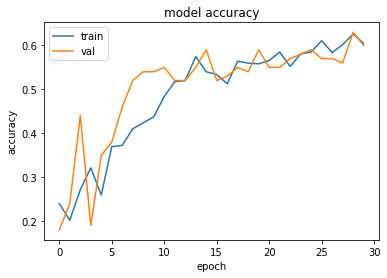

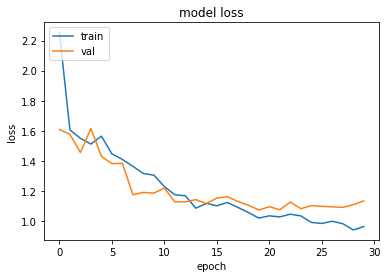

In [78]:
plot_loss_accuracy(history)

### Experiment 5 Observations
val and train loss followed same trend
val and traing accuracy are almost same

### Experiment 5 Conclusion
AveragePoolingLayer did not help much

### Experiment 6 Conv3d with same padding
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 32
- epochs: 30

In [87]:
train_generator = generator(train_data_dir, train_folder_list, batch_size=32)
val_generator = generator(val_data_dir, val_folder_list, batch_size=32)

In [88]:
from keras.layers import AveragePooling3D 
model = Sequential()
sample_shape = (20, 120, 120, 3)
no_classes = 5
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_91 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_80 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_92 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_81 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_93 (Conv3D)          (None, 5, 30, 30, 128)    221312    
                                                                 
 max_pooling3d_82 (MaxPoolin  (None, 3, 15, 15, 128) 

In [89]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [90]:
history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=32, num_epochs=30)

Source path =  /datasets/Project_data/train/ ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.8380 - categorical_accuracy: 0.2323Source path =  /datasets/Project_data/val/ ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.61376, saving model to /models/model_init_2025-03-3117_43_58.340072/model-00001-2.83800-0.23228-1.61376-0.23000.h5
21/21 [==============================] - 30s 1s/step - loss: 2.8380 - categorical_accuracy: 0.2323 - val_loss: 1.6138 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6079 - categorical_accuracy: 0.2247
Epoch 00002: val_loss improved from 1.61376 to 1.59368, saving model to /models/model_init_2025-03-3117_43_58.340072/model-00002-1.60788-0.22474-1.59368-0.21000.h5
21/21 [==============================] - 29s 1s/step - loss: 1.6079 - categorical_accuracy: 0.2247 - val_loss: 1.5937 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


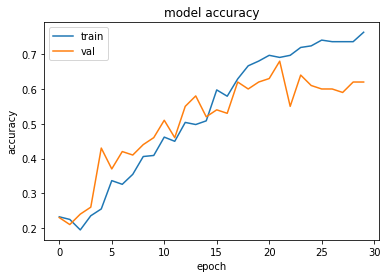

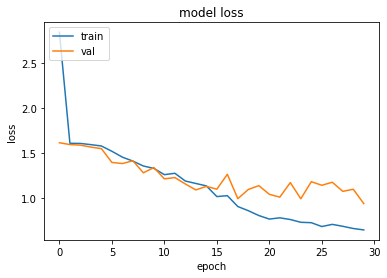

In [91]:
plot_loss_accuracy(history)

### Experiment 6 Observation
Train accuracy has been improved
val loss is stil high

### Experiment 6 Conclusion
Adding BatchNormalization in next experiment to stabilize the model

### Experiment 7 Conv3d with BatchNormalization
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 32
- epochs: 50

In [92]:
from keras.layers import BatchNormalization 
model = Sequential()
sample_shape = (20, 120, 120, 3)
no_classes = 5
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_95 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d_84 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_96 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 60, 60, 64)   256       
 hNormalization)                                                 
                                                     

In [93]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [94]:
history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=32, num_epochs=50)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 8.9843 - categorical_accuracy: 0.3228
Epoch 00001: val_loss improved from inf to 182.02045, saving model to /models/model_init_2025-03-3118_02_27.659471/model-00001-8.98427-0.32278-182.02045-0.31000.h5
21/21 [==============================] - 29s 1s/step - loss: 8.9843 - categorical_accuracy: 0.3228 - val_loss: 182.0204 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 2.7747 - categorical_accuracy: 0.3122
Epoch 00002: val_loss improved from 182.02045 to 11.18874, saving model to /models/model_init_2025-03-3118_02_27.659471/model-00002-2.77473-0.31222-11.18874-0.19000.h5
21/21 [==============================] - 28s 1s/step - loss: 2.7747 - categorical_accuracy: 0.3122 - val_loss: 11.1887 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.7383 - categorical_accuracy: 0.2971
Epoch 00003: va

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


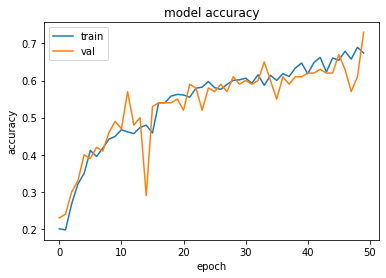

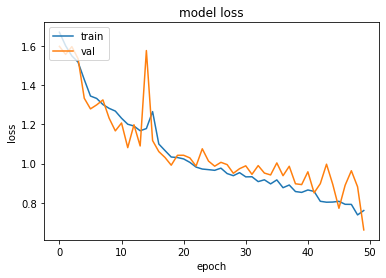

In [99]:
plot_loss_accuracy(history)

### Experiment 7 Observation

### Experiment 7 Conclusion

### Experiemt 8 CNN Transfer Learning (Resnet50) + GRU

In [96]:
from keras.layers import BatchNormalization 
model = Sequential()
sample_shape = (20, 120, 120, 3)
no_classes = 5
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_99 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_88 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 10, 60, 60, 32)    0         
                                                                 
 conv3d_100 (Conv3D)         (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_89 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 5, 30, 30, 64)   

In [97]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [98]:
history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=32, num_epochs=30)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 9.4983 - categorical_accuracy: 0.1780
Epoch 00001: val_loss improved from inf to 1.59469, saving model to /models/model_init_2025-03-3118_28_33.408407/model-00001-9.49825-0.17798-1.59469-0.23000.h5
21/21 [==============================] - 30s 1s/step - loss: 9.4983 - categorical_accuracy: 0.1780 - val_loss: 1.5947 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6108 - categorical_accuracy: 0.2006
Epoch 00002: val_loss did not improve from 1.59469
21/21 [==============================] - 29s 1s/step - loss: 1.6108 - categorical_accuracy: 0.2006 - val_loss: 1.6061 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.6023 - categorical_accuracy: 0.2202
Epoch 00003: val_loss did not improve from 1.59469
21/21 [==============================] - 29s 1s/step - loss: 1.6023 - categorical_accura

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


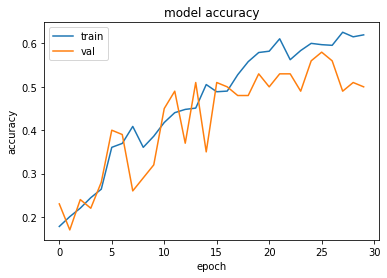

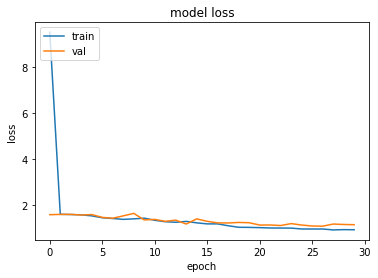

In [99]:
plot_loss_accuracy(history)

### Experiemt 8 Observations

### Experiemt 9 CNN Transfer Learning (Resnet50) + GRU

In [100]:
train_generator = generator(train_data_dir, train_folder_list, batch_size=32, img_size=(224,224))
val_generator = generator(val_data_dir, val_folder_list, batch_size=32, img_size=(224,224))

In [104]:
from keras.layers import GRU
resnet_model = ResNet50(include_top=False)
model = Sequential()
model.add(TimeDistributed(resnet_model, input_shape=(20, 224, 224, 3))) 
model.add(Reshape((-1,2048)))
model.add(GRU(128))
model.add(Dense(128, activation='relu')) 
model.add(Dense(5, activation='softmax'))
model.layers[0].trainable = False

model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 20, 7, 7, 2048)   23587712  
 tributed)                                                       
                                                                 
 reshape_2 (Reshape)         (None, 980, 2048)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               836352    
                                                                 
 dense_75 (Dense)            (None, 128)               16512     
                                                                 
 dense_76 (Dense)            (None, 5)                 645       
                                                                 
Total params: 24,441,221
Trainable params: 853,509
Non-trainable params: 23,587,712
___________________________________

In [105]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [106]:
history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=32)

Source path =  /datasets/Project_data/train/ ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6882 - categorical_accuracy: 0.2021Source path =  /datasets/Project_data/val/ ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.61473, saving model to /models/model_init_2025-03-3118_44_08.721973/model-00001-1.68817-0.20211-1.61473-0.20000.h5
21/21 [==============================] - 54s 2s/step - loss: 1.6882 - categorical_accuracy: 0.2021 - val_loss: 1.6147 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5965 - categorical_accuracy: 0.2262
Epoch 00002: val_loss improved from 1.61473 to 1.56651, saving model to /models/model_init_2025-03-3118_44_08.721973/model-00002-1.59646-0.22624-1.56651-0.28000.h5
21/21 [==============================] - 48s 2s/step - loss: 1.5965 - categorical_accuracy: 0.2262 - val_loss: 1.5665 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


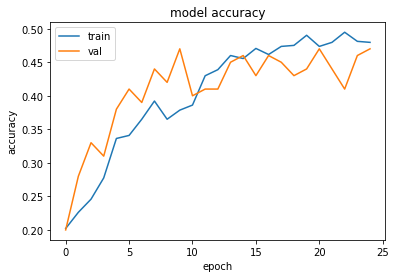

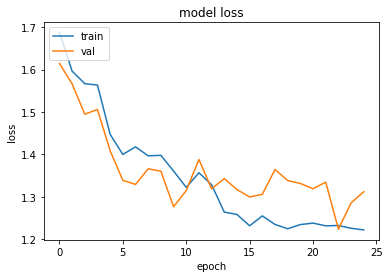

In [107]:
plot_loss_accuracy(history)

### Experiemt 10 CNN Transfer Learning (Mobilenet) + GRU

In [118]:
train_generator = generator(train_data_dir, train_folder_list, batch_size=10)
val_generator = generator(val_data_dir, val_folder_list, batch_size=10)

In [132]:
from tensorflow.keras.applications import MobileNet
from keras.layers import  MaxPooling2D
mobilenet_transfer = MobileNet(weights='imagenet', include_top=False)
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer, input_shape=(20, 224, 224, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(Reshape((-1,1024)))
model.add(GRU(128))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_37 (TimeDi  (None, 20, 7, 7, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 20, 7, 7, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 20, 3, 3, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 20, 9216)         0         
 stributed)                                                      
                                                                 
 reshape_4 (Reshape)         (None, 180, 1024)       

In [133]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [134]:
history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=10)

Epoch 1/25


InvalidArgumentError:  Input to reshape is a tensor with 8640000 values, but the requested shape requires a multiple of 150528
	 [[node sequential_74/time_distributed_37/Reshape
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/wrappers.py:260)
]] [Op:__inference_train_function_189057]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_74/time_distributed_37/Reshape:
In[0] IteratorGetNext (defined at /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:866)	
In[1] sequential_74/time_distributed_37/Reshape/shape:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_299/855125396.py", line 1, in <module>
>>>     history = train_model(model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=10)
>>> 
>>>   File "/tmp/ipykernel_299/1616618816.py", line 28, in train_model
>>>     history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/wrappers.py", line 260, in call
>>>     inputs = tf.__internal__.nest.map_structure_up_to(inputs, tf.reshape, inputs,
>>> 

In [ ]:
plot_loss_accuracy(history)